<a href="https://colab.research.google.com/github/simeonbetapudi/DeepLearningAIEthics/blob/main/Copy_of_LeaderboardCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uninstall Colab's bigframes because it conflicts with other installs
%pip uninstall -y bigframes
# Install Lightning, also let's use "rich" progress bars
%pip install -Uqq lightning wandb rich einops

Found existing installation: bigframes 2.23.0
Uninstalling bigframes-2.23.0:
  Successfully uninstalled bigframes-2.23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 26.6 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Not advocating Lightning over raw pytorch, but it offers some useful abstractions
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

In [18]:
# optional: define additional data augmentation transformers for the dataloader
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val for test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, shuffle=True, persistent_workers=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=0, shuffle=False, persistent_workers=False)
val_dl = test_dl # alias val <--> test

Data set lengths: train: 60000, test: 10000


y (target) = tensor([6, 1, 0, 6]) 
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 2: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 3: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


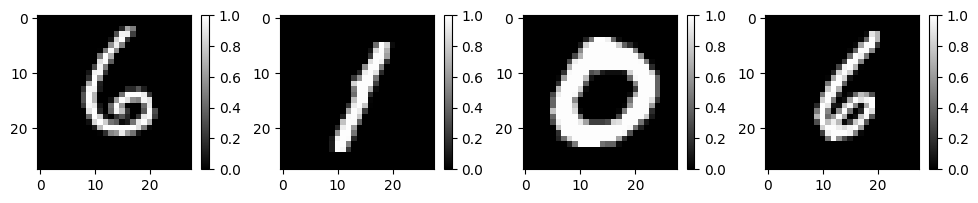

In [4]:
# @title Code for `show_xs` visualization tool
def show_xs(xs, show_stats=True):
    """A little utility to show one or more images"""
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

x, y = next(iter(train_dl))   # pick a few elements from the dataset
print(f"y (target) = {y[:4]} ")

show_xs(x[:4])

In [27]:
# @torch.no_grad()
def test_inference(model, idx=None, return_fig=False):
    import inspect
    model.eval()
    if idx is None: idx = torch.randint(len(test_ds), (1,))[0]
    if isinstance(idx, int): idx = [idx]
    elif isinstance(idx, range): idx = list(idx)
    x_batch = torch.stack([test_ds[i][0] for i in idx]).to(model.device)  # images
    y_batch = torch.tensor([test_ds[i][1] for i in idx]).to(model.device) # labels
    if not model.use_conv: x_batch = x_batch.view(x_batch.size(0), -1)
    if 1==len(inspect.signature(model.forward).parameters): # for ae or vae
        # Assuming the model's forward returns (x_hat, mu, log_var, z_hat)
        x_hat, mu, log_var, z_hat = model.forward(x_batch)
        recon = x_hat # The reconstructed image is the first element
    else:                                                   # c-vae (later in lesson)
        cond = F.one_hot(y_batch, num_classes=10).float()
        # Assuming the conditional model's forward returns (x_hat, mu, log_var, z_hat)
        x_hat, mu, log_var, z_hat = model.forward(x_batch, cond)
        recon = x_hat # The reconstructed image is the first element

    recon = recon.view(len(idx), 28, 28)
    fig, axs = plt.subplots(2, len(idx), figsize=(3*len(idx), 4))
    if len(idx) == 1: axs = axs.reshape(2, 1)
    for i in range(len(idx)):
        axs[0,i].imshow(x_batch[i].view(28,28).cpu(), cmap='gray')
        axs[1,i].imshow(recon[i].cpu(), cmap='gray')
        if i == 0:
            axs[0,0].set_ylabel('Input', fontsize=12)
            axs[1,0].set_ylabel('Reconstruction', fontsize=12)
    model.train()
    if return_fig: return fig
    plt.show()

In [6]:
class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # x1 from decoder path, x2 is skip connection from encoder
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # Concatenate skip connection (key U-Net feature!)
        return self.conv(x)

In [23]:
latent_dim = 3  # Define latent_dim before using it in class definitions

class UNetDown(nn.Module):
    def __init__(self, n_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.features = features

        self.inc = DoubleConv(n_channels, features[0])
        self.downs = nn.ModuleList([Down(features[i], features[i+1]) for i in range(len(features)-1)])
        self.flatten = nn.Flatten()

        # Dynamically calculate the input size for the linear layers
        # Pass a dummy tensor through the convolutional layers to get the output shape
        with torch.no_grad():
            dummy_input = torch.randn(1, n_channels, 28, 28) # Assuming input image size is 28x28
            x = self.inc(dummy_input)
            for down in self.downs:
                x = down(x)
            flattened_size = x.numel() // x.shape[0] # Calculate flattened size per batch

        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

    def forward(self, x):
        skip_connections = []
        x = self.inc(x)
        skip_connections.append(x)

        for down in self.downs:  # Downsampling path
            x = down(x)
            skip_connections.append(x)

        skip_connections = skip_connections[:-1]  # Remove last (bottleneck)

        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar, skip_connections


class UNetUp(nn.Module):
   def __init__(self, n_channels=1, n_classes=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.features = features

        # Dynamically calculate the input size for the linear layer in the decoder
        flattened_size = features[-1] * 4 * 4 # This size should match the output of the encoder's linear layers

        self.fc = nn.Linear(latent_dim, flattened_size)  # mirror encoder
        self.unflatten = nn.Unflatten(1, (features[-1], 4, 4))
        self.ups = nn.ModuleList([Up(features[len(features)-1-i], features[len(features)-2-i]) for i in range(len(features)-1)])
        self.outc = nn.Conv2d(features[0], n_classes, 1)

   def forward(self, bottleneck, skip_connections):
        x = self.fc(bottleneck)
        x = self.unflatten(x)

        for i, up in enumerate(self.ups):  # Upsampling path with skip connections
            skip = skip_connections[-(i+1)]
            x = up(x, skip)

        return torch.sigmoid(self.outc(x))

In [24]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self,
                 latent_dim=3,    # dimensionality of the latent space. bigger=less compression, better reconstruction
                 features=[64,128,256,512],  # intermediate/hidden layers in our simple encoder/decoder
                 act = nn.LeakyReLU,
                 ):
        super().__init__()

        # VAE encoder outputs two values, for mean and variance
        self.encoder = UNetDown(n_channels=1, features=features)

        # VAE decoder is exactly same as vanilla AE
        self.decoder = UNetUp(n_channels=1, n_classes=1, features=features)

        self.use_conv = True
        self.latent_dim, self.act = latent_dim, act # save config for archival purposes

    def reparam_sample(self, mu, log_var):
        "this yields a data value by sampling from the learned gaussian distribution of latents"
        std = torch.exp(0.5*log_var).sqrt() # the 0.5 is an optional, tunable rescaling factor.
        noise = torch.randn_like(std)       # the gaussian distribution we sample from
        return mu + std * noise

    def forward(self, x):
        # Get mu, log_var, skip_connections from encoder
        mu, log_var, skip_connections = self.encoder(x)
        # Sample from the latent space
        z_hat = self.reparam_sample(mu, log_var)
        # Decode the latent sample to reconstruct the image
        x_hat = self.decoder(z_hat, skip_connections)
        return x_hat, mu, log_var, z_hat # order chosen to preserve earlier model's outputs of z, x_hat


    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        "the basic task: make predictions, compute loss, and send to logging system"
        x, y = batch
        # Remove flattening for linear layer as we are using convolutional layers
        # x = x.view(x.size(0), -1)

        # Get outputs from the forward pass
        x_hat, mu, log_var, z_hat = self.forward(x)

        #recon_loss = nn.functional.mse_loss(x_hat, x)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x) # remember you need a sigmoid on decoder out to use bce
        # or you could use torch.nn.functional.binary_cross_entropy_with_logits without the sigmoid
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 1e-3 # larger means blurrier/blobbier
        rescaled_kl_loss = (kl_loss * scrunch_factor) # this is what goes in the loss function
        loss = recon_loss + rescaled_kl_loss

        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(f'{log_prefix}kl_loss', kl_loss)
        self.log(f'{log_prefix}rescaled_kl_loss', rescaled_kl_loss) # Corrected f-string
        return loss

    def training_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_epoch_start(self): # give us a new line for each epoch
        print('\n')

    def on_validation_epoch_end(self, demo_every=1):
        if self.current_epoch % demo_every == 0:  # log every this many epochs
            fig = test_inference(self, idx=range(5), return_fig=True)
            self.logger.experiment.log({"reconstructions": wandb.Image(fig), "epoch": self.current_epoch})
            plt.close(fig)  # clean up


vae = VAEModel()
model = vae

In [9]:
wandb.login()
# Lightning defines its own WandbLogger callback...
wandb.finish() # just in case we're aborting runs & restarting

# set up the logging
wandb_logger = WandbLogger(log_model="all", project='vae_sim')
try:
    wandb_logger.watch(model)
except:
    pass

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jaydencruz824 (jaydencruz824-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
epochs = 25  # VAEs require more steps to train than vanilla AEs, due to dual-objective loss
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar(leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃   ┃ Name    ┃ Type     ┃ Params ┃ Mode ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━┩
│ 0 │ encoder │ UNetDown │  4.7 M │ eval │
│ 1 │ decoder │ UNetUp   │  3.0 M │ eval │
└───┴─────────┴──────────┴────────┴──────┘

Trainable params: 7.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.8 M                                                                                                
Total estimated model params size (MB): 31                                                                         
Modules in train mode: 0                                                                                           
Modules in eval mode: 81

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:527: Found 82 module(s) in eval mode at
the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore
this warning.

Output()

Output()

Output()

Output()